![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer1.png)

In [ ]:
!wget "http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip"

--2021-02-18 02:55:32--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  10.7MB/s    in 0.9s    

2021-02-18 02:55:33 (10.7 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]



In [ ]:
!unzip "cornell_movie_dialogs_corpus.zip"

Archive:  cornell_movie_dialogs_corpus.zip
   creating: cornell movie-dialogs corpus/
  inflating: cornell movie-dialogs corpus/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cornell movie-dialogs corpus/
  inflating: __MACOSX/cornell movie-dialogs corpus/._.DS_Store  
  inflating: cornell movie-dialogs corpus/chameleons.pdf  
  inflating: __MACOSX/cornell movie-dialogs corpus/._chameleons.pdf  
  inflating: cornell movie-dialogs corpus/movie_characters_metadata.txt  
  inflating: cornell movie-dialogs corpus/movie_conversations.txt  
  inflating: cornell movie-dialogs corpus/movie_lines.txt  
  inflating: cornell movie-dialogs corpus/movie_titles_metadata.txt  
  inflating: cornell movie-dialogs corpus/raw_script_urls.txt  
  inflating: cornell movie-dialogs corpus/README.txt  
  inflating: __MACOSX/cornell movie-dialogs corpus/._README.txt  


In [ ]:
!python -m spacy download en
#!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
%set_env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator, Iterator
from torchtext import data

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
import pandas as pd

In [ ]:
MAX_LENGTH = 20  # Maximum sentence length in Conversations

In [ ]:
import pandas as pd
cols=["lineID","characterID","movieID","character name","utterance"]
df_movie_lines=pd.read_csv("/content/cornell movie-dialogs corpus/movie_lines.txt", sep='\+\+\+\$\+\+\+',header=None,engine='python',names=cols)

In [ ]:
df_movie_lines.head()

,lineID,characterID,movieID,character name,utterance
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [ ]:
df_movie_lines.lineID = df_movie_lines.lineID.apply(lambda x: int(x[1:]))

In [ ]:
df_movie_lines.head()

,lineID,characterID,movieID,character name,utterance
0,1045,u0,m0,BIANCA,They do not!
1,1044,u2,m0,CAMERON,They do to!
2,985,u0,m0,BIANCA,I hope so.
3,984,u2,m0,CAMERON,She okay?
4,925,u0,m0,BIANCA,Let's go.


In [ ]:
df_movie_lines = df_movie_lines.sort_values(by=['lineID'])

In [ ]:
df_movie_lines.head()

,lineID,characterID,movieID,character name,utterance
86,49,u0,m0,BIANCA,Did you change your hair?
85,50,u3,m0,CHASTITY,No.
84,51,u0,m0,BIANCA,You might wanna think about it
648,59,u9,m0,PATRICK,I missed you.
647,60,u8,m0,MISS PERKY,It says here you exposed yourself to a group ...


In [ ]:
df_movie_lines['utterance'].str.len().max()

3047.0

In [ ]:
df_movie_lines.reset_index(drop=True, inplace=True)

In [ ]:
df_movie_lines.head()

,lineID,characterID,movieID,character name,utterance
0,49,u0,m0,BIANCA,Did you change your hair?
1,50,u3,m0,CHASTITY,No.
2,51,u0,m0,BIANCA,You might wanna think about it
3,59,u9,m0,PATRICK,I missed you.
4,60,u8,m0,MISS PERKY,It says here you exposed yourself to a group ...


In [ ]:
dialogues = df_movie_lines.utterance.to_list()

In [ ]:
dialogues.pop(0)

' Did you change your hair?'

In [ ]:
dialogues.append(np.nan)

In [ ]:
df_movie_lines['reply'] = dialogues

In [ ]:
df_movie_lines.head()

,lineID,characterID,movieID,character name,utterance,reply
0,49,u0,m0,BIANCA,Did you change your hair?,No.
1,50,u3,m0,CHASTITY,No.,You might wanna think about it
2,51,u0,m0,BIANCA,You might wanna think about it,I missed you.
3,59,u9,m0,PATRICK,I missed you.,It says here you exposed yourself to a group ...
4,60,u8,m0,MISS PERKY,It says here you exposed yourself to a group ...,It was a bratwurst. I was eating lunch.


In [ ]:
df_movie_lines.count()

lineID            304713
characterID       304713
movieID           304713
character name    304713
utterance         304446
reply             304445
dtype: int64

In [ ]:
df_movie_lines['utterance'] = df_movie_lines['utterance'].astype('str')
df_movie_lines['reply'] = df_movie_lines['reply'].astype('str')
mask = ((df_movie_lines['utterance'].str.len() <= MAX_LENGTH) & (df_movie_lines['reply'].str.len() <= MAX_LENGTH))
df_movie_lines = df_movie_lines.loc[mask]

In [ ]:
df_movie_lines['utterance'].str.len().max()

20

In [ ]:
df_movie_lines.count()

lineID            23312
characterID       23312
movieID           23312
character name    23312
utterance         23312
reply             23312
dtype: int64

In [ ]:
df_movie_lines = df_movie_lines.dropna()
df_movie_lines.reset_index(drop=True, inplace=True)

In [ ]:
df_movie_lines.shape

(23312, 6)

In [ ]:
Input = data.Field(tokenize = 'spacy',
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

Output = data.Field(tokenize = 'spacy',
                    init_token='<sos>', 
                    eos_token='<eos>', 
                    lower=True)
LineId = data.Field(sequential=False, use_vocab=False)

In [ ]:
fields = [('Input', Input),('Output', Output), ('LineId', LineId)]

In [ ]:
example = [data.Example.fromlist([df_movie_lines.utterance[i],df_movie_lines.reply[i], df_movie_lines.lineID[i]], fields) for i in range(df_movie_lines.shape[0])]

In [ ]:
example[0].__dict__

{'Input': [' ', 'you', 'the', 'new', 'guy', '?'],
 'LineId': 63,
 'Output': [' ', 'so', 'they', 'tell', 'me', '...']}

In [ ]:
N = len(example)
train_len = 0.7*N


In [ ]:
train_data = data.Dataset(example[:int(train_len)], fields)
valid_data = data.Dataset(example[int(train_len):], fields)

In [ ]:
# (train_data, valid_data, test_data) = DialogueDataset.split(split_ratio=[0.70, 0.10, 0.20])
# train_data, valid_data, test_data = DialogueDataset[:int(train_len)], DialogueDataset[int(train_len+1):int(train_len+valid_len)], DialogueDataset[int(train_len+valid_len):]

In [ ]:
train_data

In [ ]:
Input.build_vocab(train_data, min_freq = 3)
Output.build_vocab(train_data, min_freq = 3)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

device

device(type='cuda')

In [ ]:
train_data[0].Input

[' ', 'you', 'the', 'new', 'guy', '?']

In [ ]:
BATCH_SIZE = 16

# train_iterator, valid_iterator = Iterator.splits((train_data, valid_data), batch_size = BATCH_SIZE, 
#                                                             sort_key = lambda x: -x.LineId,
#                                                             sort_within_batch=True, device = device)
train_iterator = BucketIterator(train_data, batch_size=BATCH_SIZE, sort=True,
                           sort_key = lambda x: -x.LineId,
                           sort_within_batch=True, device = device)
valid_iterator = BucketIterator(valid_data, batch_size=BATCH_SIZE, sort=True,
                           sort_key = lambda x: -x.LineId,
                           sort_within_batch=True, device = device)

In [ ]:
a = enumerate(train_iterator)

In [ ]:
b = next(a)

In [ ]:
b[1].LineId

tensor([449397, 449447, 449451, 449453, 449497, 449498, 449547, 449560, 449561,
        449638, 449639, 449702, 449721, 449756, 450211, 450236],
       device='cuda:0')

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 120):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 120):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

10000
11000
11100
11100
11100

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [ ]:
INPUT_DIM = len(Input.vocab)
OUTPUT_DIM = len(Output.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = Input.vocab.stoi[Input.pad_token]
TRG_PAD_IDX = Output.vocab.stoi[Output.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,932,517 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
def maskNLLLoss(inp, target, mask):
    # print(inp.shape, target.shape, mask.sum())
    nTotal = mask.sum()
    crossEntropy = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
    loss = crossEntropy(inp, target)
    loss = loss.to(device)
    return loss, nTotal.item()

In [ ]:
def original_maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [ ]:
# criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
criterion = maskNLLLoss

In [ ]:
from tqdm import tqdm
def make_trg_mask(trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != TRG_PAD_IDX).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    n_totals = 0
    print_losses = []
    for i, batch in tqdm(enumerate(iterator), total=len(iterator)):
        # print(batch)
        loss = 0
        src = batch.Input.permute(1, 0)
        trg = batch.Output.permute(1, 0)
        trg_mask = make_trg_mask(trg)
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        mask_loss, nTotal = criterion(output, trg, trg_mask)
        
        mask_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        print_losses.append(mask_loss.item() * nTotal)
        n_totals += nTotal


        
    return sum(print_losses) / n_totals

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    n_totals = 0
    print_losses = []
    
    with torch.no_grad():
    
        for i, batch in tqdm(enumerate(iterator), total=len(iterator)):

            src = batch.Input.permute(1, 0)
            trg = batch.Output.permute(1, 0)
            trg_mask = make_trg_mask(trg)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            mask_loss, nTotal = criterion(output, trg, trg_mask)

            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

        
    return sum(print_losses) / n_totals

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

  0%|          | 2/1020 [00:00<01:10, 14.37it/s]

Epoch: 01 | Time: 1m 9s
	Train Loss: 2.755 | Train PPL:  15.723
	 Val. Loss: 2.429 |  Val. PPL:  11.348


  0%|          | 2/1020 [00:00<01:07, 15.06it/s]

Epoch: 02 | Time: 1m 9s
	Train Loss: 2.467 | Train PPL:  11.790
	 Val. Loss: 2.353 |  Val. PPL:  10.518


  0%|          | 2/1020 [00:00<01:11, 14.25it/s]

Epoch: 03 | Time: 1m 9s
	Train Loss: 2.370 | Train PPL:  10.701
	 Val. Loss: 2.318 |  Val. PPL:  10.159


  0%|          | 2/1020 [00:00<01:08, 14.81it/s]

Epoch: 04 | Time: 1m 9s
	Train Loss: 2.300 | Train PPL:   9.978
	 Val. Loss: 2.301 |  Val. PPL:   9.987


100%|██████████| 438/438 [00:04<00:00, 92.56it/s]

Epoch: 05 | Time: 1m 9s
	Train Loss: 2.250 | Train PPL:   9.483
	 Val. Loss: 2.294 |  Val. PPL:   9.910


In [ ]:
SRC = Input
TRG = Output

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

# test_loss = evaluate(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

<All keys matched successfully>

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['Input']
trg = vars(train_data.examples[example_idx])['Output']

print(f'src = {src}')
print(f'trg = {trg}')

src = [' ', 'hey', '.']
trg = [' ', 'there', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = [' ', 'no', '.', '<eos>']


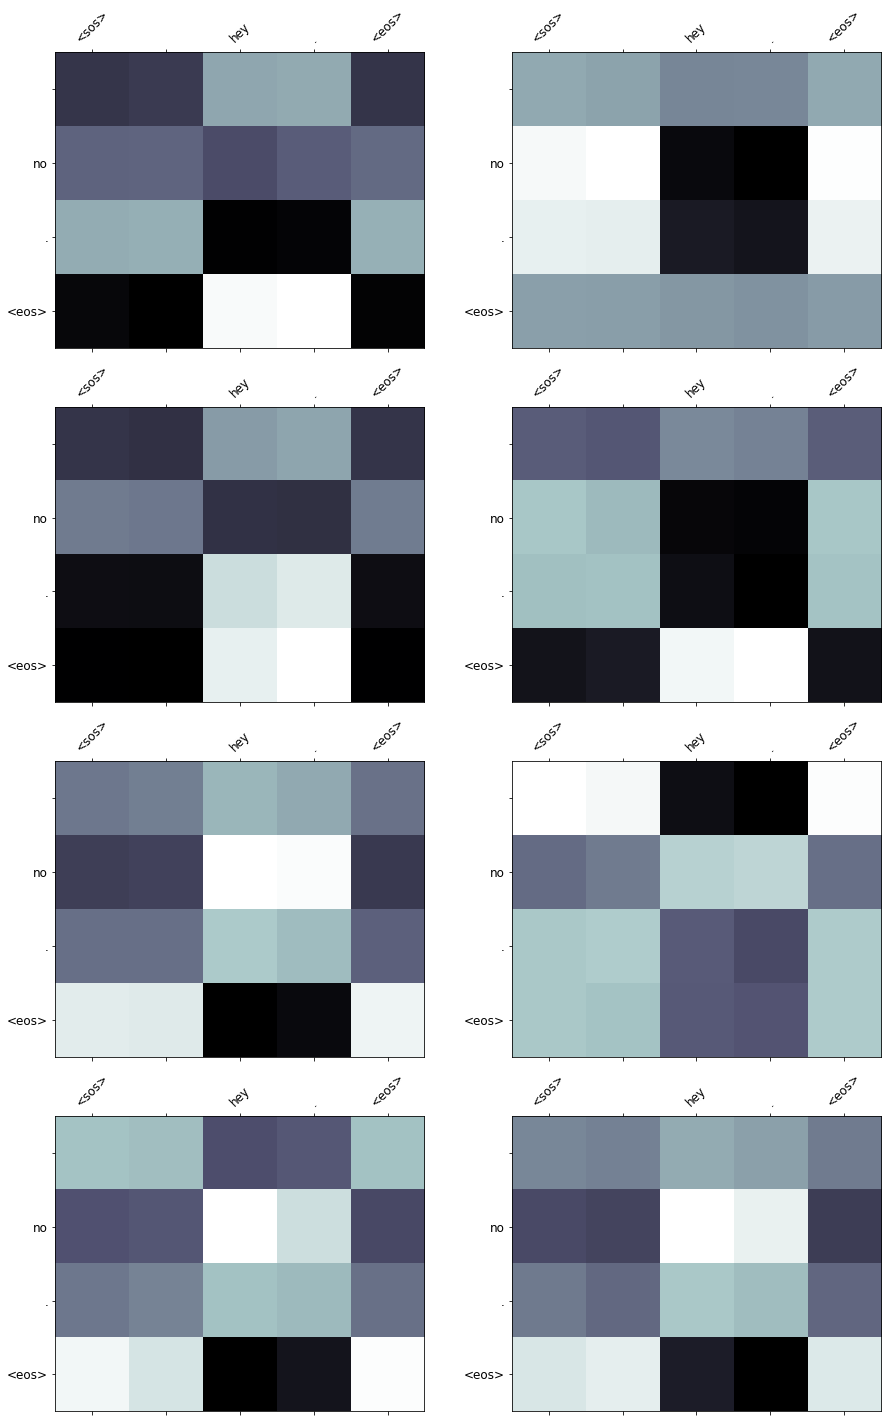

In [ ]:
display_attention(src, translation, attention)


In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['Input']
trg = vars(valid_data.examples[example_idx])['Output']

print(f'src = {src}')
print(f'trg = {trg}')

src = [' ', 'yes', 'i', 'do', '.']
trg = [' ', 'why', '?']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = [' ', 'no', '.', '<eos>']


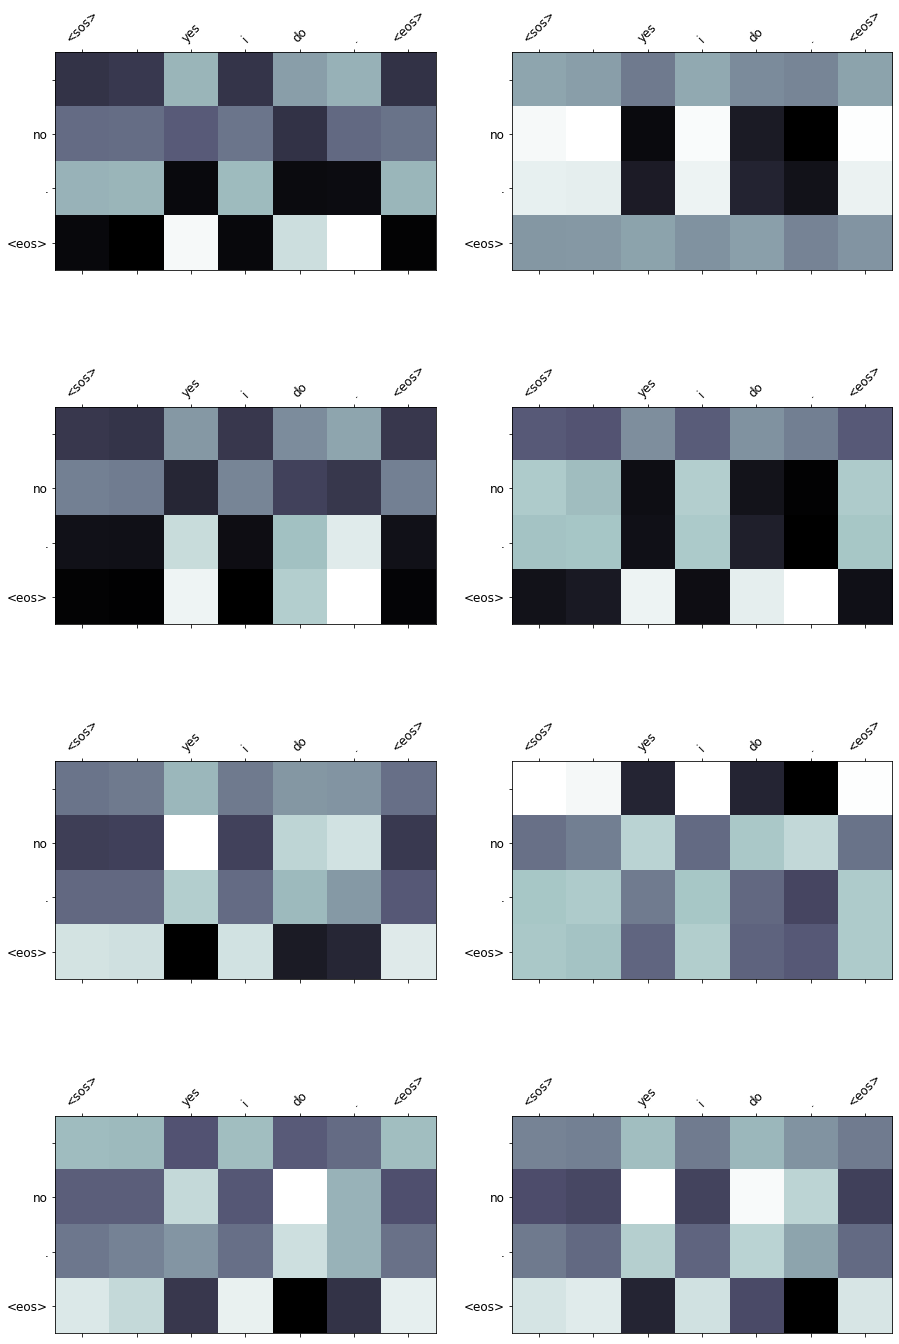

In [ ]:
display_attention(src, translation, attention)


In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['Input']
trg = vars(test_data.examples[example_idx])['Output']

print(f'src = {src}')
print(f'trg = {trg}')

NameError: ignored

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = [' ', 'no', '.', '<eos>']


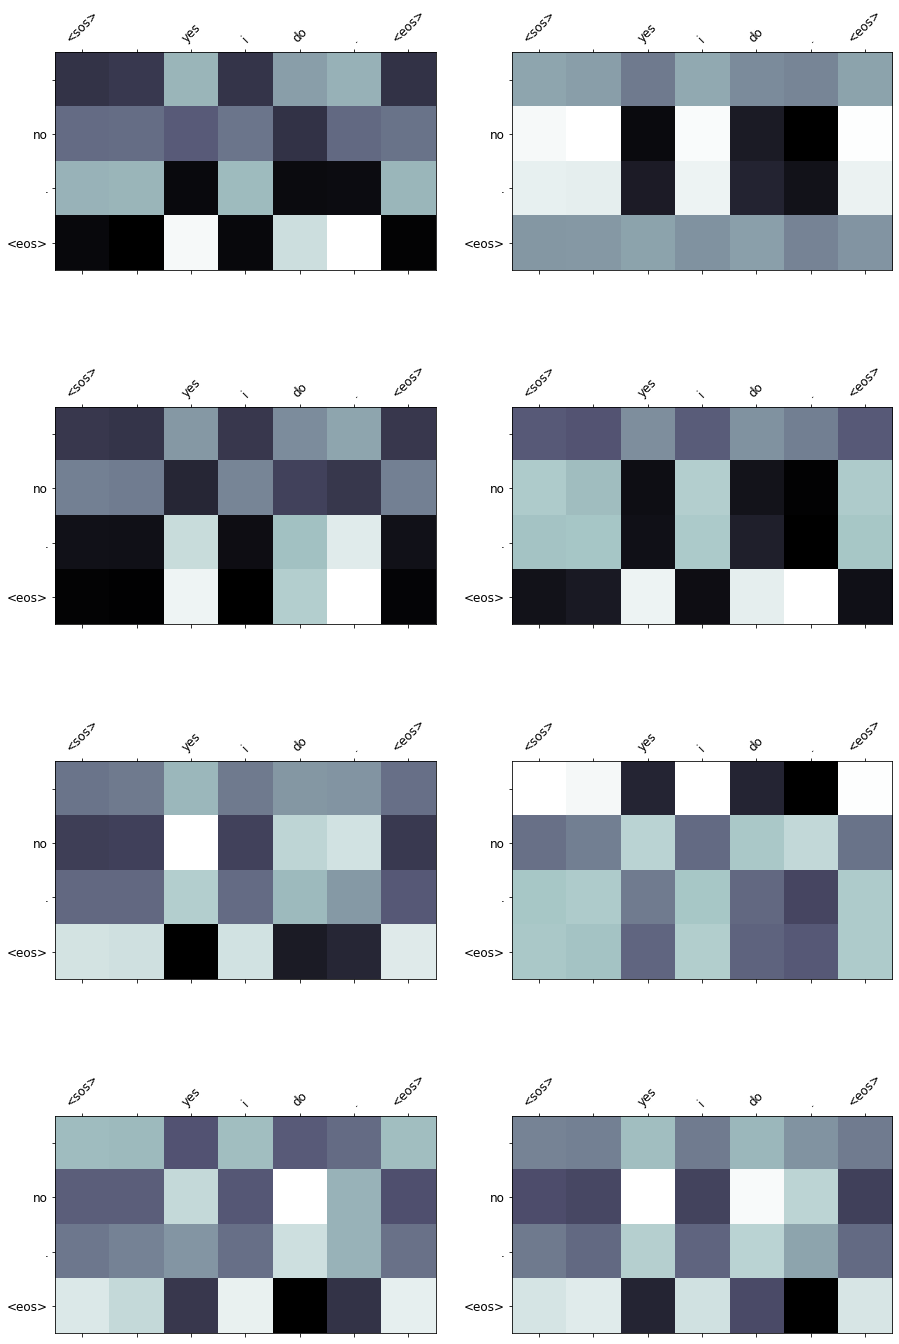

In [ ]:
display_attention(src, translation, attention)


In [ ]:
pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 1.2MB 17.9MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [ ]:
from torchtext.data.metrics import bleu_score

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

NameError: ignored